# CNN model notebook

Import libraries and modules

In [1]:
# move to the root directory of the git
%cd ..

C:\Users\DJNaj\Documents\CiTG\MSc\Year II\Q2\CEGM2003 - Data Science and Artificial Intelligence for Engineers\Unit 3 - Project\FLOOD_group2


In [2]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
#import imageio
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data.dataset import random_split
import torch.nn as nn
from torchsummary import summary
from torchviz import make_dot
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from matplotlib.colors import TwoSlopeNorm
import random
from IPython.display import Image, display

from pre_processing.encode_decode_csv import decode_from_csv

from pre_processing.process_data import *
from models.CNN_model.CNN_functions import *
from models.CNN_model.CNN_classes import *
from pre_processing.augmentation import *
from pre_processing.normalization import * 

# Creating Training Dataset

First the training dataset is created based upon a research paper by Bentivoglio et al (2023). For training and validation purposes a dataset of 80 different generated digital elevation models are used to reflect different plausible topographies. The velocity in both x and y direction (VX and VY) as well as the water depth (WD) are known, based on numerical computations utilizing Delft3D.
The code cell below uses several custom functions for the data loading and pre-processing steps

<b>decode_from_csv</b>

The Encode_to_csv notebook has been used to encode inputs and targets datasets into .csv files meant to reduce the loading time. The decode_from_csv function returns a torch tensor with length equal to number of samples. The index [:, 0] contains the inputs and [:, 1] contains the targets. Please note that this method was first developed for the ConvLSTM which also uses discharge as a target. As the CNN model does not use discharge data, this has to be removed from the tensor. This is done within the remove_discharge function.

Please refer to load_datasets.py and encode_decode_csv.py files found in the pre-processing folder for further details.

The key components of the pre-processing step include:

<b>Elevation Data Processing</b>

The process_elevation_data function takes a DEM (Digital Elevation Model) file identifier (file_id) and a dataset identifier (dataset_id) as inputs. It reads the corresponding DEM file, extracts elevation data, and calculates the slope in the x and y directions. The result is a torch tensor combining the original elevation data with its slope information.

<b>Water Depth Processing</b>

The process_water_depth function processes water depth data from a specific time step in a file. It requires a water depth file identifier (file_id), a dataset identifier (dataset_id), and an optional time step parameter (time_step, default is 0). The function reads the specified file, extracts the data for the given time step, and returns a 64x64 torch tensor representing water depth.


In [5]:
def remove_discharge(train_val_test):
    '''
    Print is located within decode_csv
    '''
    dataset = decode_from_csv(train_val_test)
    inputs = dataset[:][0]
    targets = dataset[:][1]
    targets = targets[:,:, 0].unsqueeze (2) # remove discharge
    new_dataset = TensorDataset(inputs.float(), targets.float())
    return new_dataset
train_dataset = remove_discharge('train_val')

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


# Creating the Test Dataset

Now the test dataset is created based on dataset1 from Bentivoglio et al (2023). This dataset features 20 DEMs over a squared domain of 64x64 grids of length 100 m and a simulation time of 48 h. A fixed breach location is used.

In [10]:
test_dataset = remove_discharge('test1')

Restored inputs Shape: torch.Size([20, 1, 4, 64, 64])
Restored targets Shape: torch.Size([20, 48, 2, 64, 64])


# Aplying Data augmentation

placeholder; DAVID WIP

In [11]:
# apply augmentation
transformed_dataset = augmentation(train_dataset)

The samples in the dataset before augmentation were 80
The samples in the dataset after augmentation are 160


# Splitting the Datasets

Below, the training dataset is split into training and validation sets. A standard 80/20 split is employed. 

In [12]:
# Split dataset into train and validation
random_gen = torch.Generator().manual_seed(42) # find a random seed and fix it to always have the same split

train_percent = 0.8
train_size = int(train_percent * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_dataset, val_dataset = random_split(transformed_dataset, [train_size, val_size], random_gen)

# Data Normalization

placeholder; DAVID WIP

In [13]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_y = scaler(train_dataset)

normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_y, 'train_val')
normalized_val_dataset = normalize_dataset(val_dataset, scaler_x, scaler_y, 'train_val')
norm_test_dataset = normalize_dataset(test_dataset, scaler_x, scaler_y, 'test1')

# Model summary and visualization

Now the CNN model is instantiated and a summary of the model is printed. Please refer to the '‘CNN_classes.py’' file within the CNN_model directory for further details on the defining of the CNN architecture. The model resembles a U-Net, consisting of an encoder and a corresponding decoder, connected by a bottleneck layer. In total, the model has 124,128,688 parameters, all of which are trainable.
The key components of the model architecture are:


<b>Encoder</b>

The encoder consists of multiple layers of convolution and pooling operations, gradually reducing spatial dimensions while increasing feature channels:

•	The model starts with a convolutional layer (Conv2d-1) followed by batch normalization (BatchNorm2d-2) and Rectified Linear Unit (ReLU-3).

•	This is followed by another set of convolution, batch normalization, and ReLU (DoubleConv-7).

•	Max pooling (MaxPool2d-8) is applied to reduce spatial dimensions.

•	The model then repeats the encoder structure, gradually increasing the number of channels in each block (Down-16, Down-25, Down-35).


<b>Decoder</b>

The decoder, comprised of up-sampling and convolutional layers, reconstructs the high-resolution segmentation map from the learned features:

•	The decoder begins with upsampling using transposed convolution (ConvTranspose2d-44) followed by a series of convolution, batch normalization, and ReLU operations (DoubleConv-51).

•	This process is repeated for each level of the decoder (Up-52, Up-61, Up-70, Up-79).


<b>Skip connections</b>

Skip connections are established between corresponding encoder and decoder layers, which enhance information flow between different resolutions; facilitating the preservation of fine details and improving the training stability.

In [18]:
# Instantiate the CNN
model = UNet().to(device)
summary(model, input_size=(4, 64, 64)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           4,608
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]         147,456
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              ReLU-6          [-1, 128, 64, 64]               0
        DoubleConv-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         294,912
      BatchNorm2d-10          [-1, 256, 32, 32]             512
             ReLU-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]         589,824
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

Below, the model architecture is visualized using PyTorchViz. PyTorchViz uses the following color-coding the model architecture graph:

•	Blue nodes represent tensors or variables in the computation graph. These are the data elements that flow through the operations.

•	Gray nodes represent PyTorch functions or operations performed on tensors.

•	Green nodes represent gradients or derivatives of tensors. They showcase the backpropagation flow of gradients through the computation graph.

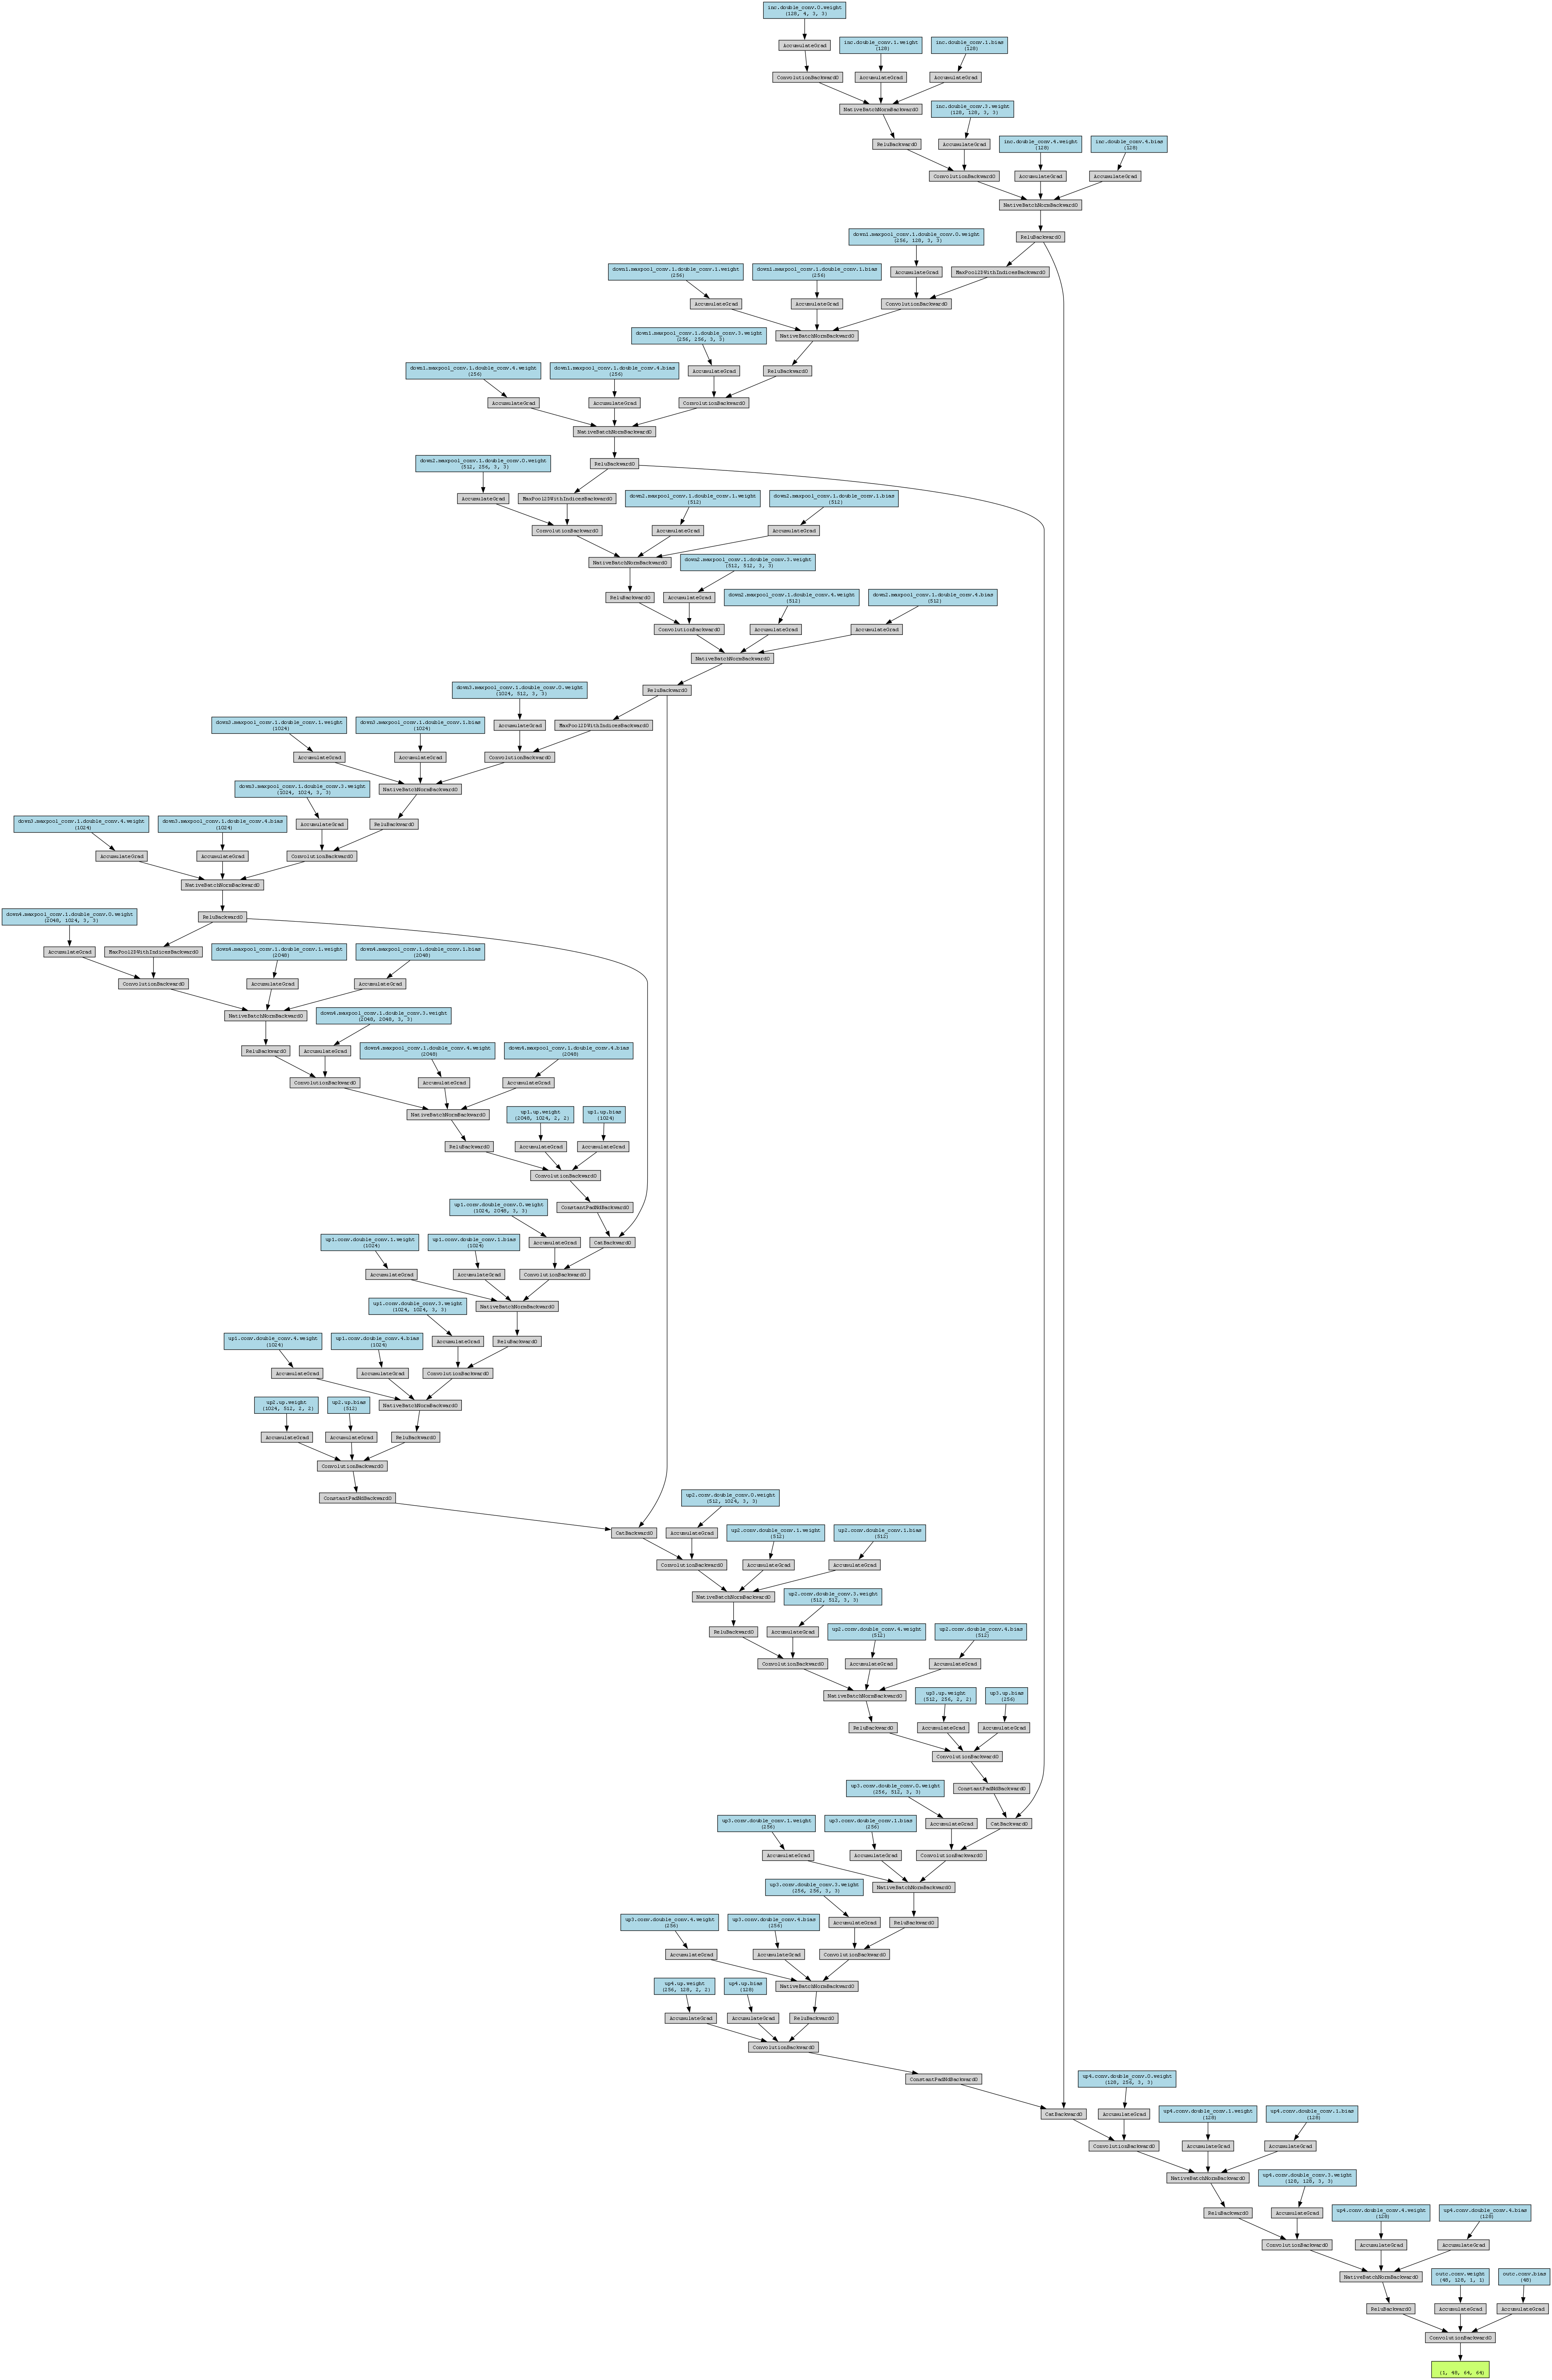

In [19]:
# Visualize the model architecture
dummy_input = torch.randn(1, 4, 64, 64).to(device)
model.eval()  # Set the model to evaluation mode
out = model(dummy_input)
graph = make_dot(out, params=dict(model.named_parameters()))
output_path = os.path.join('images', 'CNN_model_graph')
graph.render(output_path, format="png", cleanup=True)
img_path = f"{output_path}.png"
display(Image(filename=img_path))

# Model training

<b>Training Parameters</b>

First the learning rate, batch size, and the number of training epochs are specified.

In [20]:
# Set training parameters
learning_rate = 0.001
batch_size = 64
num_epochs = 100

<b>Optimizer and Dataloaders</b>

An Adam optimizer is set up to train the neural network, and dataloaders are created to efficiently handle batches of data during training and evaluation.

In [21]:
# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(normalized_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(normalized_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(norm_test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
train_dataset[0][1].shape

torch.Size([48, 1, 64, 64])

<b>Training and Evaluation Loops</b>

Here, we iterate over epochs, conducting both training and validation loops. Losses are computed and stored for each epoch, with periodic printing for monitoring.

The code cell below uses two custom functions for training and evaluating:

<b>train_epoch</b>

The train_epoch function is used for training the model. It takes as input the model architecture (model), a data loader (loader) supplying training batches, an optimizer (optimizer) for weight updates, and the computation device (device). During each training epoch, the function iterates through the provided data loader, performs forward and backward passes, computes Mean Squared Error (MSE) loss, and updates the model parameters using backpropagation.

<b>evaluation</b>

The evaluation function is used for assessing the model's performance on a validation or test dataset. Similar to train_epoch, it takes the model (model), a data loader (loader), and the computation device (device) as inputs. However, it operates in evaluation mode, meaning it disables gradient computation and only performs forward passes to compute MSE loss on the validation or test set.

In [23]:
def train_epoch(model, loader, optimizer, device):
    model.to(device)
    model.train() # specifies that the model is in training mode

    losses = []

    for batch in loader:
        x = batch[0]
        x = x[:, 0] # remove time step
        y = batch[1]
        y = y[:, :, 0] # remove part of the model that says singular feature
        x, y = x.float().to(device), y.float().to(device)
        # Model prediction
        preds = model(x)

        # MSE loss function
        loss = nn.MSELoss()(preds, y)

        losses.append(loss.cpu().detach())

        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation
        optimizer.step()  # update the weights with the optimizer
        optimizer.zero_grad(set_to_none=True)   # reset the computed gradients

    losses = np.array(losses).mean()

    return losses


def evaluation(model, loader, device):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    losses = []

    with torch.no_grad():
        for batch in loader:
            x = batch[0]
            x = x[:, 0] # remove time step
            y = batch[1]
            y = y[:, :, 0] # remove part of the model that says singular feature
            x, y = x.float().to(device), y.float().to(device)

            # Model prediction
            preds = model(x)

            # MSE loss function
            loss = nn.MSELoss()(preds, y)
            losses.append(loss.cpu().detach())

    losses = np.array(losses).mean()

    return losses

In [ ]:
# David test including early stopping
train_losses = []
validation_losses = []

best_validation_loss = float('inf')  # Initialize with a very large value
patience = 25  # Number of epochs with no improvement after which training will be stopped

for epoch in range(num_epochs):
    # Training loop
    train_loss = train_epoch(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)

    # Validation loop
    validation_loss = evaluation(model, val_loader, device=device)
    validation_losses.append(validation_loss)

    # Print the loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Validation Loss: {validation_loss:.4f}')

    # Check for early stopping
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        patience_counter = 0  # Reset patience counter since there is an improvement
    else:
        patience_counter += 1  # No improvement, increase the patience counter

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1} | Best Validation Loss: {best_validation_loss:.4f}')
        break  # Stop training

Epoch 10 | Train Loss: 0.0066 | Validation Loss: 0.7950
Epoch 20 | Train Loss: 0.0049 | Validation Loss: 0.0042
Epoch 30 | Train Loss: 0.0044 | Validation Loss: 0.0037
Epoch 40 | Train Loss: 0.0042 | Validation Loss: 0.0034
Epoch 50 | Train Loss: 0.0041 | Validation Loss: 0.0033


<b> Test Set Evaluation and Loss Plotting</b>

Below, the model is evaluated on the test set and the test loss is printed. Additionally, the training and validation losses are plotted over epochs to visualize the learning progress.

In [ ]:
test_loss = evaluation(model, test_loader, device=device)
print('Test Loss:', test_loss)

In [ ]:
plt.plot(train_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Visualizing Test Sample and Predicted Water Depth

<b>Selecting a Test Sample</b>

Here, a specific test sample is selected (data_id = 2) from the test dataset. The input data (x) and the ground truth water depth (WD) are prepared for visualization. Also, the shapes of the input data tensor (x) and the water depth tensor (WD) is printed for inspection.

In [ ]:
# select one sample
data_id = 2

x = test_dataset[data_id][0].unsqueeze(0)
x = x.float().to(device)
WD = test_dataset[data_id][1]

# Display the shapes of the input data and water depth tensor
print(f"Shape of input data (x): {x.shape}")
print(f"Shape of water depth (WD): {WD.shape}")

<b>Visualizing Input Data Channels</b>

Next, we visualize the input data channels (e.g., terrain elevation, slope in x and y directions) using different colormaps. Individual plots are generated for each channel, providing a visual representation of the input features.

In [ ]:
# Assuming the first plot represents terrain, and the subsequent plots use different colormaps
colormaps = ['terrain', 'coolwarm', 'coolwarm', 'Blues']

# Define titles for each channel
channel_titles = ['DEM', 'Slope X', 'Slope Y', f'Water Depth t={t0}']

# Plotting the input tensor (x)
x_np = x.squeeze(0).cpu().numpy()  # Convert tensor to NumPy array and remove the batch dimension
num_channels = x_np.shape[0]  # Number of channels in the input

# Plot each channel separately with different colormaps and titles
fig, axs = plt.subplots(1, num_channels, figsize=(4 * num_channels, 4))
for i in range(num_channels):
    axs[i].imshow(x_np[i], cmap=colormaps[i], origin='lower')  # Set origin to lower left and use different colormaps
    axs[i].set_title(channel_titles[i])  # Set individual titles for each channel
plt.suptitle(f'Test Sample: {data_id}')
plt.show()

<b>Visualizing Water Depth Over Time</b>

Next, the ground truth water depth tensor (WD) is visualized over time. The code generates plots for specific time steps, allowing for the examination of how water depth evolves over the given sequence.

In [ ]:
# Plotting the WD tensor
WD_np = WD.cpu().numpy()  # Convert tensor to NumPy array

# Assuming WD is a sequence of images (96 time steps)
num_time_steps = WD_np.shape[0]

# Plotting specific time steps (e.g., every 10th time step)
time_steps_to_plot = list(range(0, num_time_steps, 10))

fig, axs = plt.subplots(1, len(time_steps_to_plot), figsize=(4 * len(time_steps_to_plot), 4))
for i, timestep in enumerate(time_steps_to_plot):
    axs[i].imshow(WD_np[timestep], cmap='Blues', origin='lower')  # Set origin to lower left
    axs[i].set_title(f"Time Step {timestep + 1}")
plt.suptitle("Water Depth (WD) at Specific Time Steps")
plt.show()

<b>Predicting Water Depth and Visualization</b>

Finally, the neural network model predicts the water depth (pred_WD) for the selected test sample. The predicted water depth is then visualized over specific time steps, providing a comparison between the ground truth and predicted values.

In [ ]:
# predict the WD
pred_WD = model(x).detach()

# Convert the predicted tensor to numpy array
pred_WD_np = pred_WD.squeeze(0).cpu().numpy()  # Assuming batch dimension needs to be squeezed

# Plotting specific time steps (e.g., every 10th time step)
time_steps_to_plot_pred = list(range(0, pred_WD_np.shape[0], 10))

fig, axs = plt.subplots(1, len(time_steps_to_plot_pred), figsize=(4 * len(time_steps_to_plot_pred), 4))
for i, timestep in enumerate(time_steps_to_plot_pred):
    axs[i].imshow(pred_WD_np[timestep], cmap='Blues', origin='lower')  # Assuming 'viridis' colormap, change as needed
    axs[i].set_title(f"Predicted Time Step {timestep + 1}")
plt.suptitle(f'Predicted Water Depth at Specific Time Steps for Test Sample: {data_id}')
plt.show()